In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.decomposition import NMF
import itertools

## LOAD AND CLEAN DATA

In [2]:
#import data
beers = pd.read_csv('data/beers.csv')
brewers = pd.read_csv('data/breweries.csv')
trades = pd.read_csv('data/trades.csv')
trade_items = pd.read_csv('data/trade_items.csv')
users = pd.read_csv('data/users.csv')
ftiso = pd.read_csv('data/ftiso.csv', header=None, names=['ID','Beer ID', 'Quantity',\
                                                          'Cellar Quantity', 'User_ID',\
                                                          'Type', 'Accessible List', 'Created',\
                                                          'Modified'])
datasets = [beers, brewers, trades, trade_items, users, ftiso]

In [3]:
# Do I have enough data? How should I decide how to tier different forms of interest?

print "completed trades:  %i" %trades[(trades['User 1 Status'] == 2) & (trades['User 2 Status'] == 2)]['ID'].count()
print "proposed trades:   %i" %trades['ID'].count()
print "unique iso count:  %i" %len(ftiso[ftiso['Type'] == 'iso']['Beer ID'].unique())
print "unique ft count:   %i" %len(ftiso[ftiso['Type'] == 'ft']['Beer ID'].unique())
print "unique beer count: %i" %len(beers['ID'].unique())

completed trades:  5571
proposed trades:   18975
unique iso count:  13838
unique ft count:   22555
unique beer count: 37971


In [4]:
def preprocess_data(trades, trade_items, ftiso):
    """
    input: trades, trade_items, and ftiso tables
    output: table with user/beer pairs showing iso and proposed trades
    """
    print '___preprocessing data___'
    print 'I. get beer recipient as primary user'
    step1 = pd.merge(trade_items, trades, left_on='Trade ID', right_on='ID') # merge trade_items & trades
    step1['recipient'] = np.where(step1['User ID'] == step1['User 1 ID'], step1['User 2 ID'], step1['User 1 ID']) # add recipient column
    step2 = step1[['recipient', 'Beer ID']] # narrow to relevant columns

    print 'II. prep iso list'
    step3 = ftiso[ftiso['Type'] == 'iso'] # filter to just iso
    step4 = step3[['User_ID', 'Beer ID']] # narrow to relevant columns

    print 'III. fix col names and concat'
    step2.columns = ['user_id', 'item_id'] # recipient
    step4.columns = ['user_id', 'item_id'] # iso
    step5 = pd.concat((step2, step4), axis=0)

    print 'IV - set beers as columns and add binary values'
    print "found %i duplicate user/beer combinations" %step5.duplicated().sum() # identifies 35,271 duplicates
    step6 = step5.drop_duplicates()

    return step6

In [5]:
model_df = preprocess_data(trades, trade_items, ftiso)

# set series to datetime
date_cols = [beers['Created'], beers['Modified'], trades['Created'], trades['Updated'], \
            trade_items['Created'], trade_items['Updated'], ftiso['Created'], ftiso['Modified'], \
            brewers['Created'], brewers['Modified'], users['Created'], users['Updated']]

for col in date_cols:
    col = col.map(lambda x: pd.to_datetime(x))

___preprocessing data___
I. get beer recipient as primary user
II. prep iso list
III. fix col names and concat
IV - set beers as columns and add binary values
found 35271 duplicate user/beer combinations


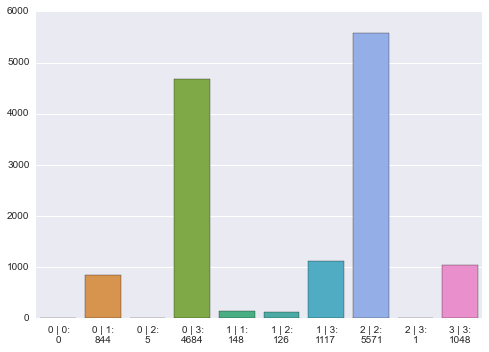

In [6]:
x = []
y = []
for i, j in itertools.combinations_with_replacement(range(4), 2):
    
    trade_count = trades[((trades['User 1 Status'] == i) & (trades['User 2 Status'] == j) | \
                (trades['User 1 Status'] == j) & (trades['User 2 Status'] == i))] \
                ['ID'].count()
    x.append("%i | %i:\n%i" %(i, j, trade_count))
    y.append(trade_count)
sns.barplot(x=x, y=y)
plt.show()

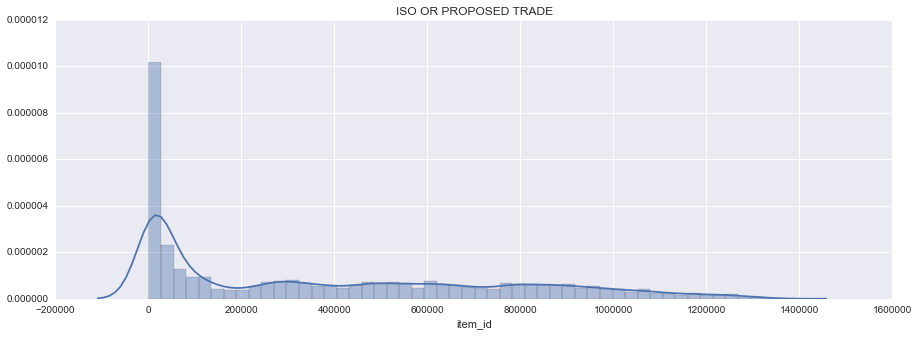

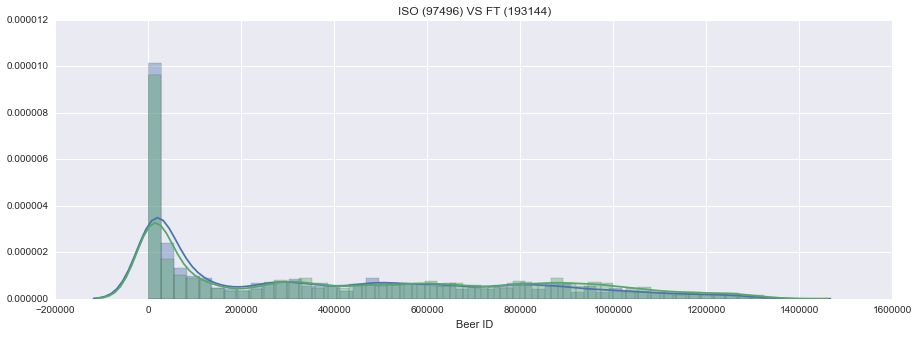

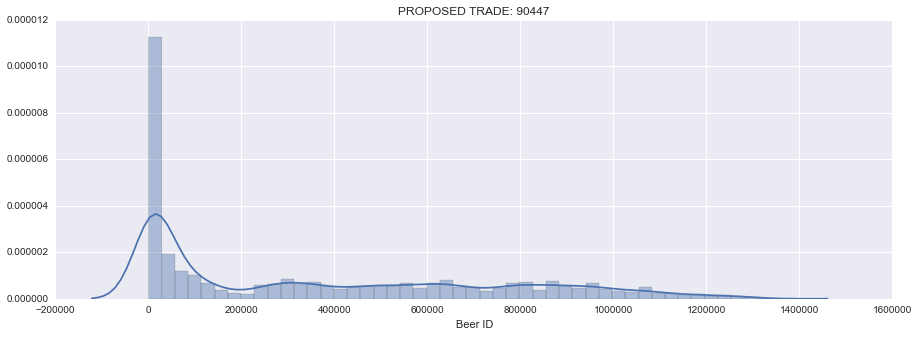

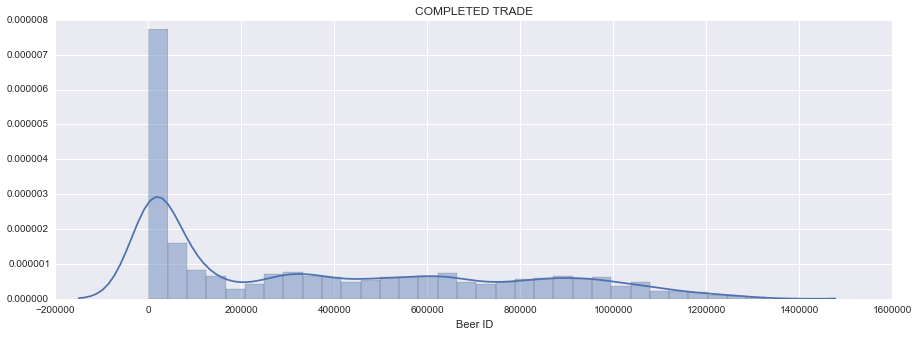

In [7]:
plt.figure(1, figsize=(15,5))
plt.title('ISO OR PROPOSED TRADE')
sns.distplot(model_df['item_id'])

plt.figure(2, figsize=(15,5))
plt.title('ISO (%i) VS FT (%i)' %(ftiso[ftiso['Type'] == 'iso']['Beer ID'].count(), ftiso[ftiso['Type'] == 'ft']['Beer ID'].count()))
sns.distplot(ftiso[ftiso['Type'] == 'iso']['Beer ID'])
sns.distplot(ftiso[ftiso['Type'] == 'ft']['Beer ID'])

plt.figure(3, figsize=(15,5))
plt.title('PROPOSED TRADE: %i' %trade_items['Beer ID'].count())
sns.distplot(trade_items['Beer ID'])

plt.figure(4, figsize=(15,5))
plt.title('COMPLETED TRADE')
full_trade = pd.merge(trade_items, trades, left_on='Trade ID', right_on='ID') # merge trade_items & trades
completed_trades = full_trade[(full_trade['User 1 Status'] == 2) & (full_trade['User 2 Status'] == 2)]['Beer ID']
sns.distplot(completed_trades)

plt.show()

## Metadata

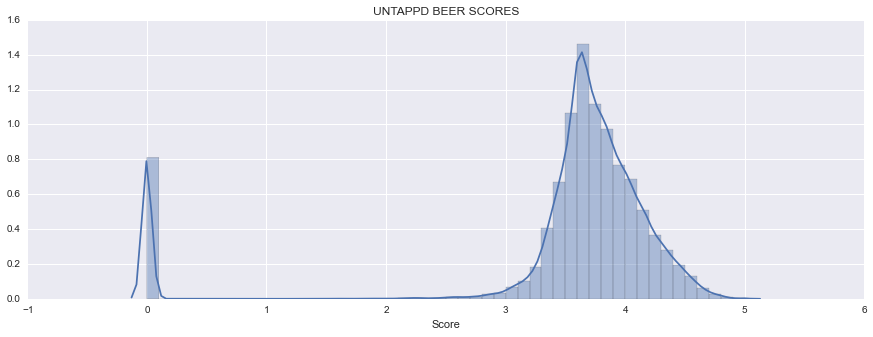

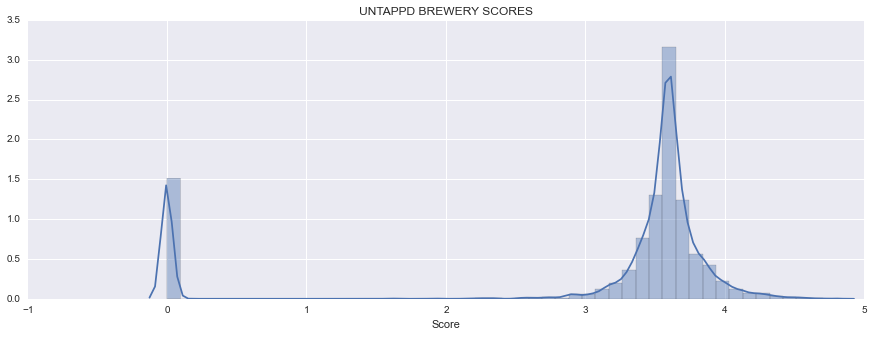

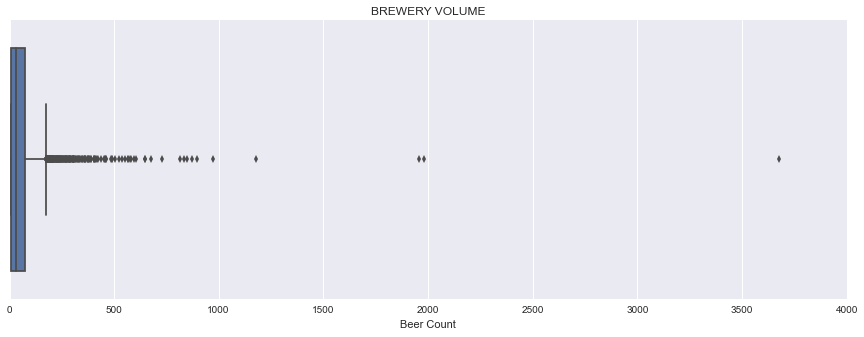

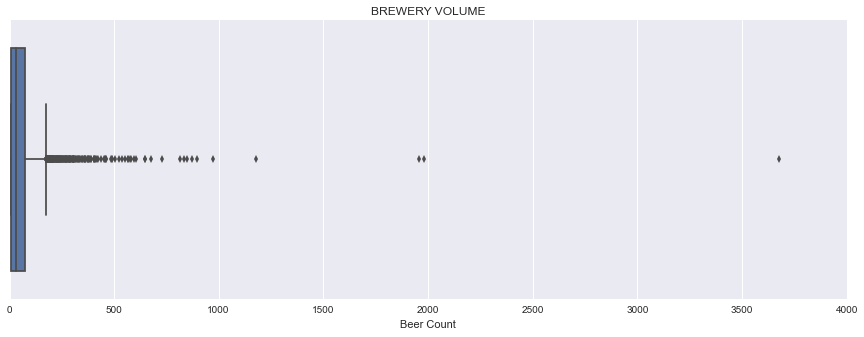

In [8]:
plt.figure(1, figsize=(15,5))
plt.title('UNTAPPD BEER SCORES')
sns.distplot(beers['Score'])

plt.figure(2, figsize=(15,5))
plt.title('UNTAPPD BREWERY SCORES')
sns.distplot(brewers['Score'])

plt.figure(3, figsize=(15,5))
plt.title('BREWERY VOLUME')
sns.boxplot(brewers['Beer Count'])
plt.show()

plt.figure(4, figsize=(15,5))
plt.title('BREWERY VOLUME')
sns.boxplot(brewers['Beer Count'])
plt.show()


In [9]:
brewers[brewers['Beer Count'] < 150].size

52740

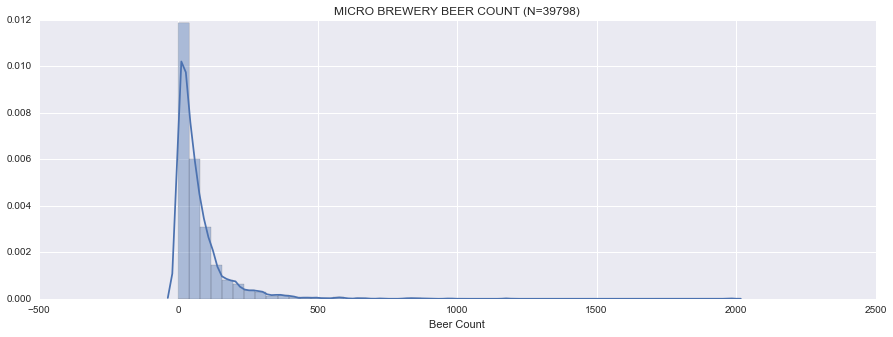

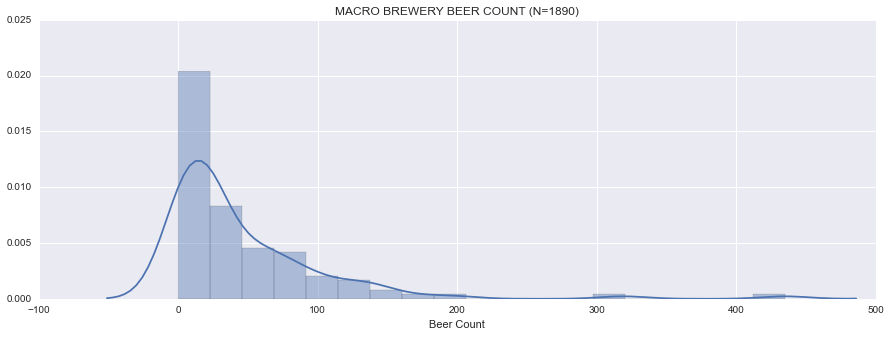

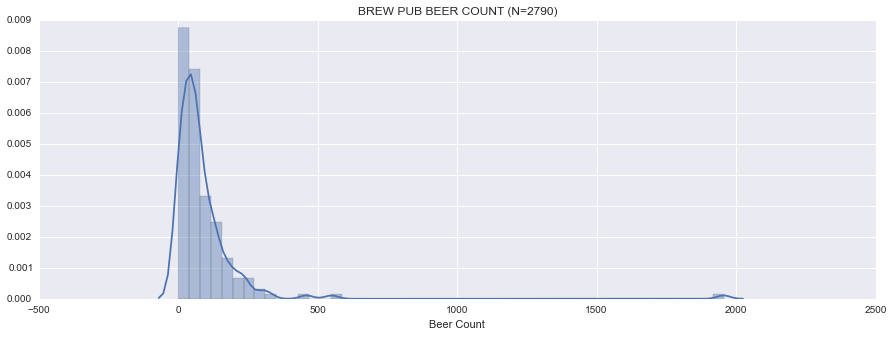

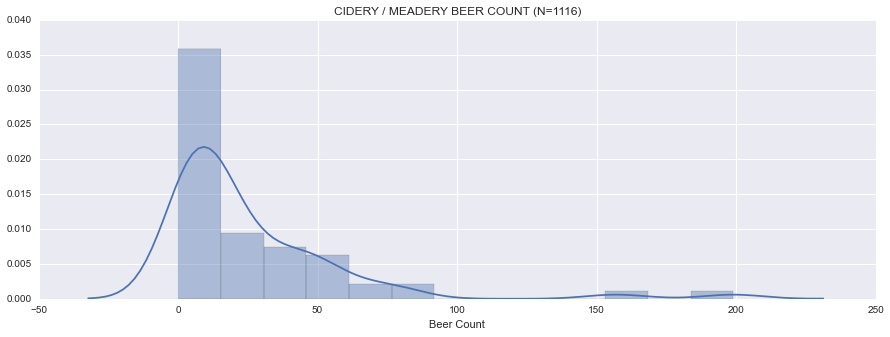

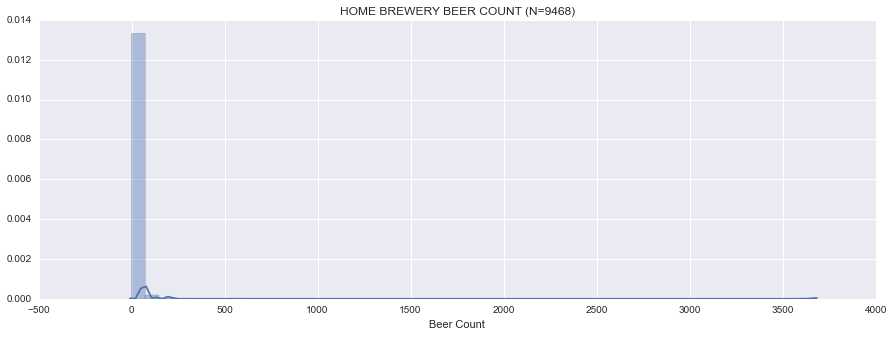

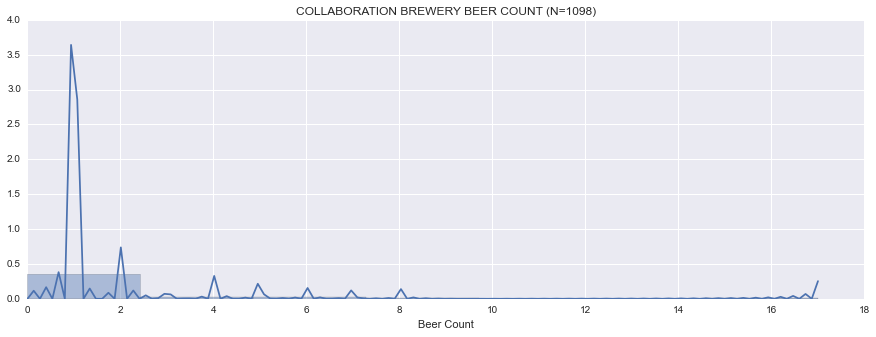

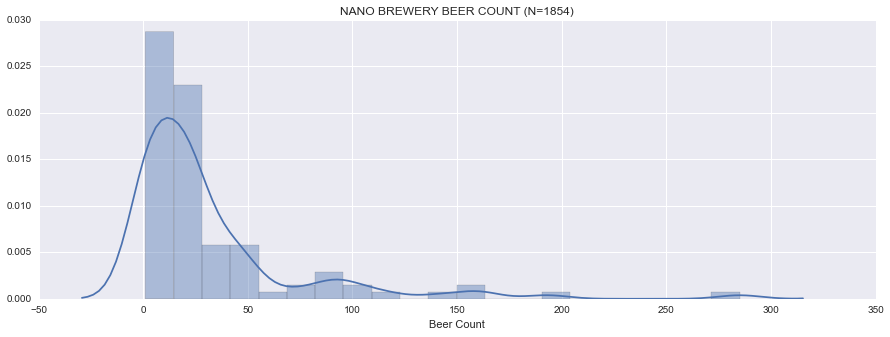

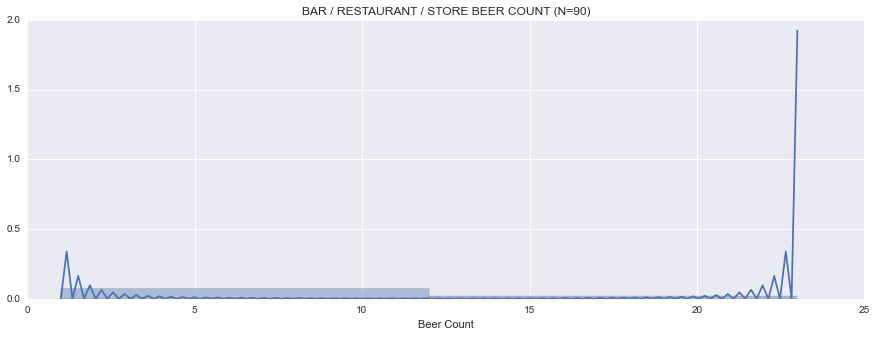

In [10]:
for i, type in enumerate(brewers['Type'].unique()):
    plt.figure(i, figsize=(15,5))
    plt.title('%s BEER COUNT (N=%i)'%(type.upper(), brewers[brewers['Type'] == type].size))
    sns.distplot(brewers[brewers['Type'] == type]['Beer Count'])

In [11]:
brewers.columns

Index([u'ID', u'Name', u'Type', u'Description', u'Label', u'Address', u'City',
       u'State', u'Country', u'Lat', u'Long', u'Beer Count', u'Twitter',
       u'Facebook', u'URL', u'Score', u'Created', u'Modified'],
      dtype='object')

In [12]:
regress_df = pd.merge(beers, brewers, left_on='Brewery ID', right_on='ID') # add breweries to beers

print 'I. ft & iso counts'
ft = ftiso[ftiso['Type'] == 'ft'].groupby(['Beer ID']).size()
regress_df = pd.merge(regress_df, ft.to_frame(name='ft'), how='left', left_on='ID_x', right_index=True) # add ft counts

iso = ftiso[ftiso['Type'] == 'iso'].groupby(['Beer ID']).size()
regress_df = pd.merge(regress_df, iso.to_frame(name='iso'), how='left', left_on='ID_x', right_index=True) # add ft counts

print 'II. proposed & completed trade counts'
# proposed trade masks
step1 = pd.merge(trade_items, trades, left_on='Trade ID', right_on='ID') # merge trade_items & trades
step1['recipient'] = np.where(step1['User ID'] == step1['User 1 ID'], step1['User 2 ID'], step1['User 1 ID']) # add recipient column

# identify times when the recipient has proposed a trade
m_user_status_1 = \
    ((step1['User 1 Status'] == 1) & (step1['recipient'] == step1['User 1 ID'])) | \
    ((step1['User 2 Status'] == 1) & (step1['recipient'] == step1['User 2 ID']))
# identify instances if recipient proposing, then declining trade (0/3)
m_user_status_03 = \
    ((step1['User 1 Status'] == 3) & (step1['User 2 Status'] == 0) & \
    (step1['recipient'] == step1['User 1 ID'])) | \
    ((step1['User 2 Status'] == 3) & (step1['User 1 Status'] == 0) & \
    (step1['recipient'] == step1['User 2 ID']))

# completed trade masks
m_user_status_2 = \
    ((step1['User 1 Status'] == 2) & (step1['recipient'] == step1['User 1 ID'])) | \
    ((step1['User 2 Status'] == 2) & (step1['recipient'] == step1['User 2 ID']))

# reduce to relevant columns
step1['prop_trade'] = (m_user_status_1 | m_user_status_03) * 1
step1['complete_trade'] = m_user_status_2 * 1
step2 = step1[['Beer ID', 'prop_trade', 'complete_trade']] # narrow to relevant columns
step3 = step2.groupby('Beer ID').sum()

# add columns to regress_df
regress_df = pd.merge(regress_df, step3, how='left', left_on='ID_x', right_index=True) # add trades to df
style_dummies = pd.get_dummies(regress_df['Style'])

print 'III. filter columns'
regress_df = regress_df[['Score_x', 'Style', 'ABV', 'Lat', 'Long', 'Beer Count', 'Score_y', 'ft', 'iso', 'prop_trade', 'complete_trade']]
regress_df.columns = ['beer_score', 'style', 'abv', 'lat', 'long', 'production', 'brewer_score', 'ft', 'iso', 'p_trade', 'c_trade']

print "IV. (don't) narrow styles"
print 'V. style dummies'
# regress_df = regress_df.append(style_dummies)
regress_df.columns

I. ft & iso counts
II. proposed & completed trade counts
III. filter columns
IV. (don't) narrow styles
V. style dummies


Index([u'beer_score', u'style', u'abv', u'lat', u'long', u'production',
       u'brewer_score', u'ft', u'iso', u'p_trade', u'c_trade'],
      dtype='object')

In [13]:
step1 = pd.merge(trade_items, trades, left_on='Trade ID', right_on='ID') # merge trade_items & trades
step1['recipient'] = np.where(step1['User ID'] == step1['User 1 ID'], step1['User 2 ID'], step1['User 1 ID']) # add recipient column

print 'II. build masks'
# proposed trade masks

# identify times when the recipient has proposed a trade
m_user_status_1 = \
    ((step1['User 1 Status'] == 1) & (step1['recipient'] == step1['User 1 ID'])) | \
    ((step1['User 2 Status'] == 1) & (step1['recipient'] == step1['User 2 ID']))
# identify instances if recipient proposing, then declining trade (0/3)
m_user_status_03 = \
    ((step1['User 1 Status'] == 3) & (step1['User 2 Status'] == 0) & \
    (step1['recipient'] == step1['User 1 ID'])) | \
    ((step1['User 2 Status'] == 3) & (step1['User 1 Status'] == 0) & \
    (step1['recipient'] == step1['User 2 ID']))

# completed trade masks
m_user_status_2 = \
    ((step1['User 1 Status'] == 2) & (step1['recipient'] == step1['User 1 ID'])) | \
    ((step1['User 2 Status'] == 2) & (step1['recipient'] == step1['User 2 ID']))

# add rating column
step1['prop_trade'] = (m_user_status_1 | m_user_status_03) * 1
step1['complete_trade'] = m_user_status_2 * 1
step2 = step1[['recipient', 'Beer ID', 'prop_trade', 'complete_trade']]
step3 = step2.groupby('Beer ID').sum()
step3.head()

II. build masks


,recipient,prop_trade,complete_trade
Beer ID,,,
28,314088,5,25
30,17084,0,2
43,43473,1,2
45,9698,1,0
47,36454,3,0


## Power User Analysis

In [14]:
data_dist = model_df.drop('v', axis=1)
data_dist = data_dist[data_dist.groupby('user_id').item_id.transform(len) > 1]
power_user_mask = list(data_dist[data_dist.groupby('user_id').item_id.transform(len) > 500]['user_id'])
power_users = data_dist[data_dist['user_id'].isin(power_user_mask)]
print power_users['user_id'].unique().size

ValueError: labels ['v'] not contained in axis

In [ ]:
for i, user in enumerate(power_users['user_id'].unique()):
    plt.figure(i, figsize=(8,3))
    sns.distplot(power_users[power_users['user_id'] == user]['item_id'], bins=100)
plt.show()

In [ ]:
    def preprocess_model_data(self, sparse=2, outlier=500,
                              iso_rate=1, proposed_rate=2, traded_rate=3):
        """Return user/item/rating table excluding sparse and outlying users

        Arguments:
        - Ratings applied to represent user beer/interactions
          (in search of, proposed trade, completed trade)
        - Sparse & outlier: the min & max number of user/beer interactions
        """

        # merge trade_items with trades and add recipient column to identify the user who wants the relevant beer in trade_items
        step1 = pd.merge(self.trade_items, self.trades, left_on='Trade ID', right_on='ID', how='left')
        step1['recipient'] = np.where(step1['User ID'] == step1['User 1 ID'], step1['User 2 ID'], step1['User 1 ID'])
        self.verbose('| PREPROCESSING | merged trade_items and trades into %i item df, added recipient column' % step1.size)

        # identify trades proposed by the recipient (recipient/sender 1/anything)
        m_proposed_trade = \
            ((step1['User 1 Status'] == 1) & (step1['recipient'] == step1['User 1 ID'])) | \
            ((step1['User 2 Status'] == 1) & (step1['recipient'] == step1['User 2 ID']))
        self.verbose('| PREPROCESSING | %i proposed trades identified' % sum(m_proposed_trade * 1))
        # identify instances of recipient proposing trade, then rescinding trade proposal (recipient/sender 3/0)
        m_rescinded_trade = \
            ((step1['User 1 Status'] == 3) & (step1['User 2 Status'] == 0) & \
            (step1['recipient'] == step1['User 1 ID'])) | \
            ((step1['User 2 Status'] == 3) & (step1['User 1 Status'] == 0) & \
            (step1['recipient'] == step1['User 2 ID']))
        self.verbose('| PREPROCESSING | %i proposed, then rescinded trades identified' % sum(m_rescinded_trade * 1))
        # identify completed trades (recipient/sender 2/anything)
        m_completed_trade = \
            ((step1['User 1 Status'] == 2) & (step1['recipient'] == step1['User 1 ID'])) | \
            ((step1['User 2 Status'] == 2) & (step1['recipient'] == step1['User 2 ID']))
        self.verbose('| PREPROCESSING | %i completed trades identified' % sum(m_completed_trade * 1))
        # add rating column for trades
        step1['prop_trade'] = (m_proposed_trade | m_rescinded_trade) * proposed_rate
        step1['complete_trade'] = m_completed_trade * traded_rate
        step1['rating'] = step1[['prop_trade', 'complete_trade']].max(axis=1)
        step2 = step1[['recipient', 'Beer ID', 'rating']]

        # applying iso rating
        step3 = self.ftiso[self.ftiso['Type'] == 'iso']
        step4 = step3[['User ID', 'Beer ID']]
        step4['rating'] = iso_rate
        self.verbose('| PREPROCESSING | %i iso entries identified' % step4.size)

        # concatatenating trade recipient data with iso list
        step2.columns = ['user_id', 'item_id', 'rating']
        step4.columns = ['user_id', 'item_id', 'rating']
        step5 = pd.concat((step2, step4), axis=0)
        step5 = step5.groupby(['user_id', 'item_id']).max()

        # dropping sparse users, outliers, & zeros (if applicable)
        m_sparse = step5.groupby('user_id').item_id.transform(len) >= sparse
        m_outlier = step5.groupby('user_id').item_id.transform(len) <= outlier
        step6 = step5[m_sparse & m_outlier]
        step6 = step6[step6['rating'] != 0]
        self.verbose('| PREPROCESSING | dropped %i sparse users, %i outliers' % (sum(m_sparse * 1), sum(m_outlier * 1)))

        self.model_df = step6
        self.verbose('| PREPROCESSING | built df with %i observations' % step6.size)